### Import Libraries

In [35]:
from nltk.corpus import stopwords
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import string
import fitz
import pickle

### Load Data

In [43]:
directory = os.listdir('2023 Competitor Docs')
data = []

for state_folder in directory:
    state_path = '2023 Competitor Docs/' + state_folder
    state_directory = os.listdir(state_path)

    for county_folder in state_directory:
        county_path = state_path + '/' + county_folder
        county_directory = os.listdir(county_path)

        for provider in county_directory:
            provider_path = county_path + '/' + provider
            provider_directory = os.listdir(provider_path)

            for plan_name in provider_directory:
                plan_path = provider_path + '/' + plan_name
                plan_directory = os.listdir(plan_path)

                for file in plan_directory:
                    file_path = plan_path + '/' + file
                    pdf_file = fitz.open(file_path)

                    text = ''

                    for page in pdf_file:
                        extracted_text = page.get_text()
                        text += extracted_text + '\n\n'
                    
                    data.append([state_folder, county_folder, provider, plan_name, file, text])

documents = pd.DataFrame(data, columns = ['state', 'county', 'provider', 'plan_name', 'file', 'text'])

In [44]:
documents.head()

,state,county,provider,plan_name,file,text
0,Illinois,IL - Chicago,UnitedHealthcare,NEW $0 HMO-POS (H2802-054-000),H2802-054-000_UHC_IL_Chicago_HMOPOS_BenefitHig...,Benefit Highlights\nAARP® Medicare Advantage P...
1,Illinois,IL - Chicago,UnitedHealthcare,NEW $0 HMO-POS (H2802-054-000),H2802-054-000_UHC_IL_Chicago_HMOPOS_VendorShee...,Vendor Information\nAARP® Medicare Advantage P...
2,Illinois,IL - Chicago,UnitedHealthcare,NEW $0 HMO-POS (H2802-054-000),H2802-054-000_UHC_IL_Chicago_HMOPOS_SOB.pdf,Summary of\nBenefits 2023\nAARP® Medicare Adva...
3,Illinois,IL - Chicago,UnitedHealthcare,Access $0 HMO-POS (H2802-024-000),H2802-024-000_UHC_IL_Chicago_Access_BenefitHig...,Benefit Highlights\nAARP® Medicare Advantage A...
4,Illinois,IL - Chicago,UnitedHealthcare,Access $0 HMO-POS (H2802-024-000),H2802-024-000_UHC_IL_Chicago_Access_SOB.pdf,Summary of\nBenefits 2023\nAARP® Medicare Adva...


### Load Target

In [4]:
benefits_grid = pd.read_csv('Benefits Grid.csv')

In [80]:
benefits_grid = benefits_grid.rename(columns = {'CONTRACT_PLAN': 'contract_plan'})
benefits_grid['contract_plan'] = benefits_grid['contract_plan'].str.replace(' ', '')

In [81]:
benefits_grid.head()

,County,Provider,contract_plan,PLAN_CATEGORY,Medicaid Coverage Categories (For D-SNP plans only),Enrolls All Duals (Y/N),"Types of Chronic Conditions (C-SNP only) (Diabetes, Coronary Artery Diseases, Cardiovascular Disorders, COPD, ESRD)",VBID (Y/N),Annual Max,Annual Max - Shared Allowance (Y/N),...,PERS Coverage,Meals Vendor,Wig Chemo,Caregiver Support,Worldwide Benefit Structure,Companion Services,Behavioral Health Vendor,DME Vendor,Nurse Line Vendor,Nurse Line 24/7 (Y/N)
0,AL: Birmingham,"UnitedHealth Group, Inc.",H0432-009-000,D-SNP HMO,"FBDE, QDWI, QI, QMB, QMB+, SLMB, SLMB+",Y,NaN,Y,"$3,000",Y,...,$0 button wrist/pendant; covers the subscription,Mom’s Meals®,NC,NC,UNK,NC,UNK,UNK,NurseLine,Y
1,AL: Birmingham,"UnitedHealth Group, Inc.",H2802-044-000,D-SNP HMO,"QMB+, QMB, QDWI, QI, SLMB+, SLMB, FBDE",Y,NaN,Y,"$2,000",Y,...,$0 button wrist/pendant; Lifeline will provide...,Mom’s Meals®,NC,NC,UNK,NC,UNK,UNK,NurseLine,Y
2,AL: Birmingham,"Triton Health Systems, LLC",H0154-012-000,D-SNP HMO,"QMB+, QMB, QDWI, QI, SLMB+, SLMB, FBDE",Y,NaN,Y,"$2,250",NaN,...,NC,NC,NC,NC,"$50,000\nannual coverage limit for emergent\nc...",NC,UNK,UNK,Viva Health Contractor,Y
3,AL: Birmingham,"UnitedHealth Group, Inc.",H2802-041-000,Zero MAPD HMO,NaN,NaN,NaN,N,"$2,000",Y,...,$0 button wrist/pendant; covers the subscripti...,Mom’s Meals®,NC,NC,UNK,NC,UNK,UNK,NurseLine,Y
4,AL: Birmingham,"Triton Health Systems, LLC",H0154-015-001,Zero MAPD HMO,NaN,NaN,NaN,NaN,"$1,000",Y,...,NC,N/C,NC,NC,"$50,000\nannual coverage limit for emergent\nc...",NC,UNK,UNK,Viva Health Contractor,Y


### Join Documents to Target

In [82]:
plan_list = benefits_grid['contract_plan']

In [103]:
def find_contract_plan(file_name):
    for plan in plan_list:
        if plan in file_name:
            return plan

In [104]:
documents['contract_plan'] = documents.apply(lambda row : find_contract_plan(row['file']), axis = 1)

In [105]:
documents.head()

,state,county,provider,plan_name,file,text,contract_plan
0,Illinois,IL - Chicago,UnitedHealthcare,NEW $0 HMO-POS (H2802-054-000),H2802-054-000_UHC_IL_Chicago_HMOPOS_BenefitHig...,Benefit Highlights\nAARP® Medicare Advantage P...,None
1,Illinois,IL - Chicago,UnitedHealthcare,NEW $0 HMO-POS (H2802-054-000),H2802-054-000_UHC_IL_Chicago_HMOPOS_VendorShee...,Vendor Information\nAARP® Medicare Advantage P...,None
2,Illinois,IL - Chicago,UnitedHealthcare,NEW $0 HMO-POS (H2802-054-000),H2802-054-000_UHC_IL_Chicago_HMOPOS_SOB.pdf,Summary of\nBenefits 2023\nAARP® Medicare Adva...,None
3,Illinois,IL - Chicago,UnitedHealthcare,Access $0 HMO-POS (H2802-024-000),H2802-024-000_UHC_IL_Chicago_Access_BenefitHig...,Benefit Highlights\nAARP® Medicare Advantage A...,None
4,Illinois,IL - Chicago,UnitedHealthcare,Access $0 HMO-POS (H2802-024-000),H2802-024-000_UHC_IL_Chicago_Access_SOB.pdf,Summary of\nBenefits 2023\nAARP® Medicare Adva...,None


In [115]:
dataset = pd.merge(benefits_grid, documents, how = 'inner', on = ['contract_plan'])

### Clean Data

In [117]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'\S*@\S*\s*','', text)
    text = text.replace('\n',' ')
    text = "".join([char for char in text if char not in string.punctuation])
    
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    cleaned_words = [word for word in tokens if word not in stop_words]
    
    return cleaned_words

In [118]:
dataset['text_cleaned'] = dataset.apply(lambda row : clean_text(row['text']), axis = 1)

In [119]:
dataset

,County,Provider,contract_plan,PLAN_CATEGORY,Medicaid Coverage Categories (For D-SNP plans only),Enrolls All Duals (Y/N),"Types of Chronic Conditions (C-SNP only) (Diabetes, Coronary Artery Diseases, Cardiovascular Disorders, COPD, ESRD)",VBID (Y/N),Annual Max,Annual Max - Shared Allowance (Y/N),...,DME Vendor,Nurse Line Vendor,Nurse Line 24/7 (Y/N),state,county,provider,plan_name,file,text,text_cleaned
0,AL: Huntsville,CIGNA,H4513-054-000,Zero MAPD HMO,NaN,NaN,NaN,N,"$1,250",Y,...,UNK,UNK,Y,Alabama,AL - Huntsville,Cigna,HMO,CignaPreferredMedicareHMO_SOB_H4513-054-000.pdf,Y0036_23_835509_M \n \n \n \n \n \nAddendum to...,"[y003623835509m, addendum, 2023, summary, bene..."
1,CO: Denver,"Kaiser Foundation Health Plan, Inc.",H0630-014-000,D-SNP HMO,UNK,UNK,NaN,N,"$1,000",Y,...,UNK,UNK,Y,Colorado,CO - Denver,Kaiser (Additional Pull 12-19),DSNP Denver,H0630-014-000_Kaiser_CO_Denver_DSNPHMO_EOC.pdf,H0630_23002DB_C \n \nPBP #: 014 \nOMB Approval...,"[h063023002dbc, pbp, 014, omb, approval, 09381..."
2,CO: Denver,"Kaiser Foundation Health Plan, Inc.",H0630-014-000,D-SNP HMO,UNK,UNK,NaN,N,"$1,000",Y,...,UNK,UNK,Y,Colorado,CO - Denver,Kaiser (Additional Pull 12-19),DSNP Denver,H0630-014-000_Kaiser_CO_Denver_DSNPHMO_SOB.pdf,H0630_23007DB_M \nPBP #: 014 \n903405343 \nJan...,"[h063023007dbm, pbp, 014, 903405343, january, ..."
3,CO: Denver Metro,"UnitedHealth Group, Inc.",H0609-048-000,Zero MAPD HMO,NaN,NaN,NaN,NaN,"$2,000",Y,...,UNK,NurseLine,Y,Colorado,CO - Denver,UnitedHealthcare,$0 HMO-POS Plan 1 (H0609-048-000),H0609-048-000_UHC_CO_Denver_Plan1HMOPOS PLUS T...,Vendor Information\nAARP® Medicare Advantage P...,"[vendor, information, aarp, medicare, advantag..."
4,CO: Denver Metro,"UnitedHealth Group, Inc.",H0609-048-000,Zero MAPD HMO,NaN,NaN,NaN,NaN,"$2,000",Y,...,UNK,NurseLine,Y,Colorado,CO - Denver,UnitedHealthcare,$0 HMO-POS Plan 1 (H0609-048-000),H0609-048-000_UHC_CO_Denver_Plan1HMOPOS_ANOC.pdf,Annual Notice of\nChanges 2023\nAARP® Medicare...,"[annual, notice, changes, 2023, aarp, medicare..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,TX: Corpus Christi,"UnitedHealth Group, Inc.",H1278-016-000,Zero MAPD PPO,NaN,NaN,NaN,N,"$500/$1,500 (optional)",Y,...,NaN,NurseLine,Y,Texas,TX - Corpus Christi,UnitedHealthcare,$0 PPO (H1278-016-000),H1278-016-000_UHC_TX_CorpusChristi_ZeroPPO_Ben...,Benefit Highlights\nAARP® Medicare Advantage C...,"[benefit, highlights, aarp, medicare, advantag..."
497,TX: Corpus Christi,"UnitedHealth Group, Inc.",H1278-016-000,Zero MAPD PPO,NaN,NaN,NaN,N,"$500/$1,500 (optional)",Y,...,NaN,NurseLine,Y,Texas,TX - Corpus Christi,UnitedHealthcare,$0 PPO (H1278-016-000),H1278-016-000_UHC_TX_CorpusChristi_ZeroPPO_ANO...,Annual Notice of\nChanges 2023\nAARP® Medicare...,"[annual, notice, changes, 2023, aarp, medicare..."
498,TX: Corpus Christi,"UnitedHealth Group, Inc.",H1278-016-000,Zero MAPD PPO,NaN,NaN,NaN,N,"$500/$1,500 (optional)",Y,...,NaN,NurseLine,Y,Texas,TX - Corpus Christi,UnitedHealthcare,$0 PPO (H1278-016-000),H1278-016-000_UHC_TX_CorpusChristi_ZeroPPO_Ven...,Vendor Information\nAARP® Medicare Advantage C...,"[vendor, information, aarp, medicare, advantag..."
499,TX: El Paso & TX: Houston,CIGNA,H4513-066-000,Giveback MAPD HMO,NaN,NaN,NaN,N,"$20,000",Y,...,NaN,UNK,Y,Texas,TX - San Antonio,Cigna,HMO,CignaPreferredSavingsHMO_SOB_H4513-066-000.pdf,Y0036_23_835509_M \n \n \n \n \n \nAddendum to...,"[y003623835509m, addendum, 2023, summary, bene..."


In [121]:
dataset_file = open('dataset', 'ab')
pickle.dump(dataset, dataset_file)
dataset_file.close()

### EDA

In [43]:
all_words = [words for document in dataset['words'] for words in document]
word_count = {}

for word in all_words:
    if word not in word_count:
        word_count[word] = 0
    word_count[word] += 1

top_words = dict(sorted(word_count.items(), key=lambda item: item[1], reverse = True)[:20])

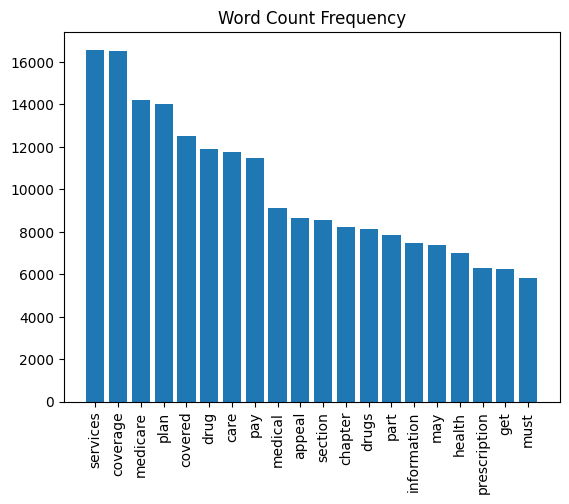

In [50]:
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.xticks(rotation = 90)
plt.title('Word Count Frequency')
plt.show()

In [52]:
dataset['word_count'].mean()

46807.619047619046

In [60]:
' Humana_H1036054000EOC23.pdf'.split('_')[0]

' Humana'